In [64]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

In [51]:
import numpy as np
import pandas as pd

In [52]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [54]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
 # Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [60]:
 # Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


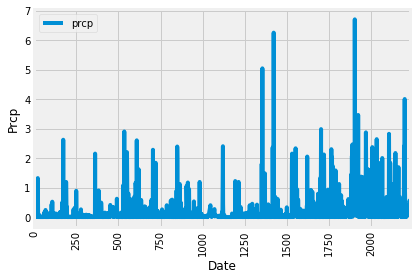

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date


first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
first_date

# Perform a query to retrieve the date and precipitation scores

precipitation = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= first_date).all()

ptps = list(np.ravel(precipitation))

ptps

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
#df.set_index('date', inplace=True)
df = df.dropna(how='any')
x_axis=df['date']
y_axis=df['prcp']


# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the date
df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Prcp")


plt.show()


![precipitation](Images/precipitation.png)

In [65]:
# Use Pandas to calculate the summary statistics for the precipitation data
mean_sum = np.mean(df['prcp'])
median_sum = np.median(df['prcp'])
mode_sum = sts.mode(df['prcp'])
var_sum = np.var(df['prcp'],ddof = 0)
sd_sum = np.std(df['prcp'],ddof = 0)

print(f"The statisticasl summary for the precipitaion data es:\n Mean:{mean_sum},\n Median: {median_sum},\n Mode: {mode_sum},\n Variance: {var_sum},\n SD: {sd_sum}.")


The statisticasl summary for the precipitaion data es:
 Mean:0.17727857496288996,
 Median: 0.02,
 Mode: ModeResult(mode=array([0.]), count=array([874])),
 Variance: 0.2125905156666475,
 SD: 0.4610753904370168.


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(Station).count()
print(stations_available)

9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_order=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations_order

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
first_station=session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()

first_station

first_station_t =pd.DataFrame(list(np.ravel(first_station)))

first_station_t[0:1]

temp_summary=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station=="USC00519281").all()
temp_summary



[(54.0, 85.0, 71.66378066378067)]

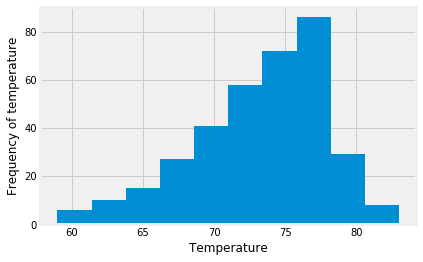

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_ranking=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

station_last_year = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= first_date).\
        filter (Measurement.station=="USC00519281").all()

df_station_last_year= pd.DataFrame(station_last_year, columns=['date', 'tobs'])

plt.hist(df_station_last_year['tobs'])
plt.xlabel("Temperature")
plt.ylabel("Frequency of temperature")
plt.show()




![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_result=calc_temps('2017-02-28', '2017-03-05')
                         
df_trip_result= pd.DataFrame(trip_result, columns=['min', 'avg','max'])

df_trip_result

,min,avg,max
0,64.0,72.027778,78.0


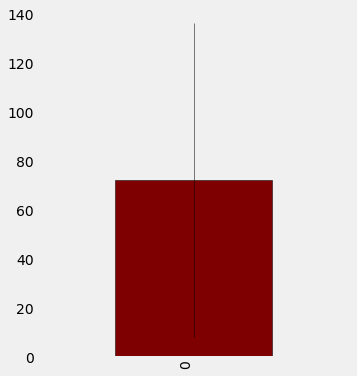

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your 
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
plot = df_trip_result['avg'].plot(kind='bar',yerr=[df_trip_result['min'],df_trip_result['max']],colormap='OrRd_r',edgecolor='black',grid=False,figsize=(5,6),ax=ax,position=0.45,error_kw=dict(ecolor='black',elinewidth=0.5))
plt.show()

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prcp(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
        filter(Measurement.station==Station.station).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

# function usage example
print(calc_prcp('2017-02-28', '2017-03-05'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.720000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.07), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.7399999999999998), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.32), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.1600000000000001)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


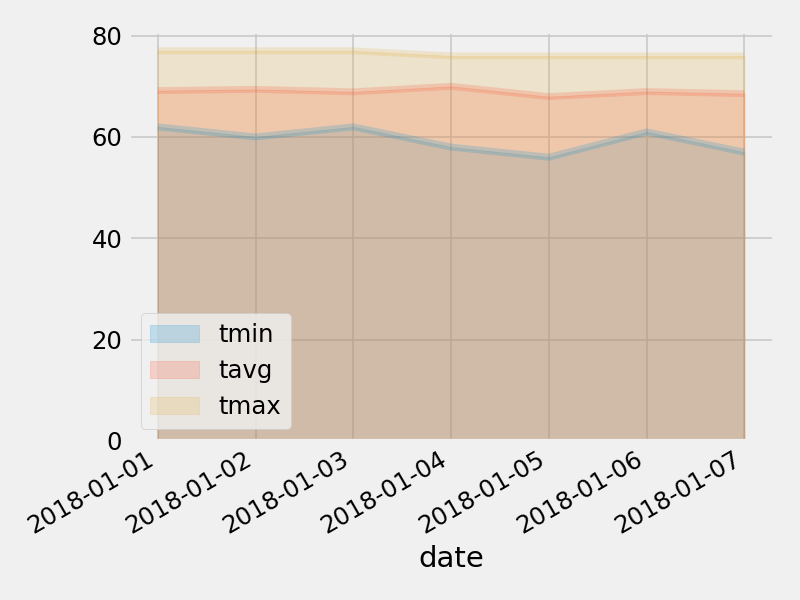

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
